# Importing required libraries

In [1]:
# General utility libraries
import os
from datetime import datetime, timedelta

# Data manipulation and analysis libraries
import pandas as pd
import numpy as np

# Geospatial analysis libraries
import geopandas as gpd
import h3
from shapely.geometry import Polygon

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap

# Spatial analysis libraries
import libpysal as lp
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot

# Machine learning and optimization libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
import pulp
from pulp import LpProblem, LpVariable, lpSum, LpMinimize

# Networking library
import requests

/Users/abhishekmacbook/tensorflow-test/env/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/nj/3wdmb9mx53x9w6dl1g51bm7m0000gn/T/ipykernel_30788/3247761240.py:10: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, thi

# Data Preparation 

In [2]:
# Reading data from a Parquet file into a pandas DataFrame.
data = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/ambulance-data/ambulance_jan_01_10.parquet")

# Removing any duplicate rows in the DataFrame.
data = data.drop_duplicates()

# Removing the timezone information from 'observationDateTime' and extracting just the date and time.
data['observationDateTime'] = data['observationDateTime'].apply(lambda x: str(x).split('+')[0])

# Creating a new column 'time' by extracting the time from 'observationDateTime'.
data['time'] = data['observationDateTime'].apply(lambda x: str(x).split(' ')[1])

# Function to round time to the nearest 5 minutes.
def round_to_5min(x):
    # Subtracting the remainder of the division by 5 from the minutes to round it off.
    p = str(int(str(x).split(':')[1]) - int(str(x).split(':')[1]) % 5)
    # Returning the time with minutes rounded to the nearest 5 and seconds set to '00'.
    return str(x).split(':')[0] + ':' + p + ':00'

# Applying the 'round_to_5min' function to the 'time' column and storing the result in a new column 'roundedTime'.
data['roundedTime'] = data['time'].apply(lambda x: round_to_5min(x))

# Extracting 'latitude' from 'location.coordinates' and converting it to float.
data['latitude'] = data['location.coordinates'].apply(lambda x: float(x.strip('[]').split(', ')[1]))

# Extracting 'longitude' from 'location.coordinates' and converting it to float.
data['longitude'] = data['location.coordinates'].apply(lambda x: float(x.strip('[]').split(', ')[0]))

# Creating a new column 'h3_hexagons' with H3 indexes representing geographical locations.
data["h3_hexagons"] = data.apply(lambda x: h3.geo_to_h3(x.latitude, x.longitude, 7), axis=1)

# Filtering out data where the ambulance service is not on duty.
data = data[data['serviceOnDuty'] != 'NO']

# Creating a DataFrame 'justToShow1' for overview, containing selected columns.
justToShow1 = data[["license_plate", 'roundedTime', 'latitude', 'longitude', 'h3_hexagons', 'serviceOnDuty', 'emergencyVehicleType']]

# Specifying the times to filter the data.
times_to_filter = ['15:50:00', '15:55:00', '15:45:00', '15:40:00', '15:35:00', '15:30:00']

# Filtering the data based on the specified times.
data = data[data['roundedTime'].isin(times_to_filter)]

# Creating a final DataFrame 'justToShow' after filtering, containing selected columns for analysis or reporting.
justToShow = data[["license_plate", "h3_hexagons", 'roundedTime', 'latitude', 'longitude', 'serviceOnDuty', 'emergencyVehicleType']]

# Displaying the 'justToShow' DataFrame.
justToShow

,license_plate,h3_hexagons,roundedTime,latitude,longitude,serviceOnDuty,emergencyVehicleType
69313,KA01G6713,8761892f0ffffff,15:30:00,13.054233,77.717285,YES,AMBULANCE
69314,KA51G5022,8760145a6ffffff,15:30:00,12.937833,77.569794,YES,AMBULANCE
69317,KA51G5256,876189244ffffff,15:30:00,12.872642,77.651756,YES,AMBULANCE
69318,KA02G3769,87618925dffffff,15:30:00,12.919616,77.591576,YES,AMBULANCE
69319,KA51G5246,87618924effffff,15:30:00,12.884981,77.596596,YES,AMBULANCE
...,...,...,...,...,...,...,...
686881,KA51G5254,87618925bffffff,15:55:00,12.950812,77.595421,YES,AMBULANCE
686882,KA51G5247,8760145a9ffffff,15:55:00,12.932542,77.461655,YES,AMBULANCE
686884,KA51G5250,8760145b5ffffff,15:55:00,12.962785,77.573181,YES,AMBULANCE
686885,KA51G5041,87618925bffffff,15:55:00,12.953297,77.592453,YES,AMBULANCE


# Optimal no. and location of Accident Hotspots using KNN

/var/folders/nj/3wdmb9mx53x9w6dl1g51bm7m0000gn/T/ipykernel_30788/349077936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['h3_hex'] = df.apply(lambda row: h3.geo_to_h3(row['latitude'], row['longitude'], resolution), axis=1)
/Users/abhishekmacbook/tensorflow-test/env/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)
/var/folders/nj/3wdmb9mx53x9w6dl1g51bm7m0000gn/T/ipykernel_30788/349077936.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hex_geo['latitude'] = hex_geo['

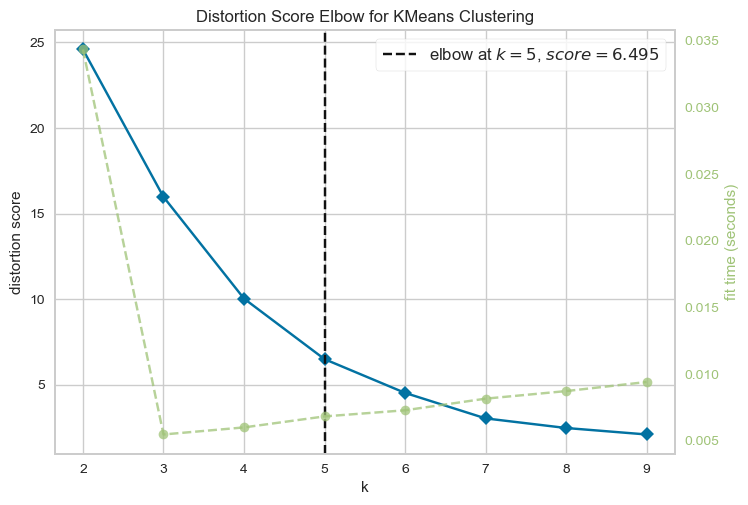

Hotspot Cluster 1 Center - Latitude: 12.946320769003167, Longitude: 77.51828127545991
Hotspot Cluster 2 Center - Latitude: 12.985908911372901, Longitude: 77.61158959552456
Hotspot Cluster 3 Center - Latitude: 12.937339767003413, Longitude: 77.59181369191228
Hotspot Cluster 4 Center - Latitude: 13.075964685370183, Longitude: 77.51200879457396
Hotspot Cluster 5 Center - Latitude: 12.984582359756322, Longitude: 77.56017527579402


/Users/abhishekmacbook/tensorflow-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [3]:
df = justToShow
# Convert latitude and longitude to H3 hexagons
resolution = 7  # Adjust the resolution as needed
df['h3_hex'] = df.apply(lambda row: h3.geo_to_h3(row['latitude'], row['longitude'], resolution), axis=1)

# Count ambulances in each hexagon
hex_counts = df['h3_hex'].value_counts()
hex_counts = pd.DataFrame({'h3_hex': hex_counts.index, 'count': hex_counts.values})

# Create a GeoDataFrame for the hexagons
hex_geo = gpd.GeoDataFrame(hex_counts, geometry=hex_counts['h3_hex'].apply(lambda x: Polygon(h3.h3_to_geo_boundary(x, geo_json=True))), crs='EPSG:4326')

# Calculate spatial weights matrix
w = lp.weights.Queen.from_dataframe(hex_geo)

# Calculate Local Moran's I
local_moran = Moran_Local(hex_geo['count'], w)

# Combine Local Moran's I results with hex_geo
hex_geo['Local_Moran'] = local_moran.q

# Extract coordinates for k-means clustering (using centroids) as separate latitude and longitude columns
hex_geo['latitude'] = hex_geo['geometry'].centroid.y
hex_geo['longitude'] = hex_geo['geometry'].centroid.x

# Create a DataFrame for k-means clustering with latitude and longitude columns
coordinates = hex_geo[['latitude', 'longitude']].values

# Create a folium map centered on the data points
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Customize the colormap and legend for the hotspot map
colors = {
    "Hotspot": "red",
    "Cold Spot": "blue",
    "Other": "gray"  # Customize for other categories as needed
}

# Initialize lists to store coordinates of hotspots
hotspot_coordinates = []

# Classify hexagons based on your interpretation of Local Moran's I results
for idx, row in hex_geo.iterrows():
    cluster = local_moran.q[idx]
    if cluster == 1:
        label = "Hotspot"
        hotspot_coordinates.append([row['latitude'], row['longitude']])
    elif cluster == 3:
        label = "Cold Spot"
    else:
        label = "Other"
    
    color = colors[label]
    
    style_function = lambda x, color=color: {'fillColor': color, 'color': color, 'weight': 1, 'fillOpacity': 0.6}
    folium.GeoJson(row['geometry'], style_function=style_function).add_to(m)

# Convert hotspot coordinates to a DataFrame for k-means clustering
hotspot_df = pd.DataFrame(hotspot_coordinates, columns=['latitude', 'longitude'])

# Scale the data for k-means clustering (normalize both count and distance)
scaler = StandardScaler()
scaled_hotspot_df = scaler.fit_transform(hotspot_df)

# Use the KElbowVisualizer to find the optimal number of clusters (k)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))  # Adjust the range of k as needed
visualizer.fit(scaled_hotspot_df)
visualizer.show()

# Get the optimal k from the visualizer (e.g., visualizer.elbow_value_)
optimal_k = visualizer.elbow_value_

# Perform k-means clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(scaled_hotspot_df)

# Get the cluster centers in the scaled format
cluster_centers_scaled = kmeans.cluster_centers_

# Inverse transform the cluster centers to the original scale (latitude and longitude)
cluster_centers_original_scale = scaler.inverse_transform(cluster_centers_scaled)

# Now, cluster_centers_original_scale contains the latitude and longitude of the hotspot cluster centers
for idx, center in enumerate(cluster_centers_original_scale):
    print(f"Hotspot Cluster {idx + 1} Center - Latitude: {center[0]}, Longitude: {center[1]}")

# Add center of hotspots to the map
for idx, center in enumerate(cluster_centers_original_scale):
    folium.CircleMarker(location=center, radius=10, color='yellow', fill=True, fill_color='orange').add_to(m)

# Display the map
m

# Introduction:
The script performs spatial analysis on geographical data points, identifying hotspots and cold spots using Local Moran's I statistics, and further clustering these hotspots using the K-means algorithm. The analysis results are visualized on an interactive map.

# Input:
A dataset containing geographical coordinates (latitude and longitude).
The dataset is pre-processed to convert coordinates into H3 hexagons and count occurrences within each hexagon.

# Process:
1. Spatial Weights Calculation:
Using Queen contiguity from libpysal to establish relationships between hexagons based on geometry.

2. Local Moran's I Calculation:
Identifying spatial autocorrelation and classifying each point as part of a hotspot, cold spot, or neither.

3. Interactive Map Creation:
Initializing a folium map and customizing the color scheme for different classifications.

4. Hotspot Identification:
Extracting coordinates of hotspots based on Local Moran's I results.

5. Data Scaling for Clustering:
Normalizing hotspot coordinates.

6. Optimal Cluster Number Determination:
Using the Elbow method to find the optimal number of clusters for K-means.

7. K-means Clustering:
Applying K-means clustering to the scaled hotspot data.

8. Cluster Center Identification:
Retrieving the geographical centers of the identified clusters.

9. Visual Result Enhancement:
Adding cluster centers to the interactive map with distinct markers.

# Output:
An interactive map displaying:

Geographical areas classified as hotspots, cold spots, or neutral areas.
Centers of identified hotspot clusters.
Console output listing the coordinates of each cluster center.

# Explanation of Results:
Spatial Autocorrelation: The Local Moran's I statistic reveals areas of high value concentration (hotspots) and low value concentration (cold spots), indicating spatial autocorrelation. These areas may represent regions of interest, such as high crime rates, disease outbreaks, or areas of affluence.

Hotspot Clustering: The clustering of hotspots serves to identify centers of activity or interest. For instance, in urban planning, these clusters could indicate areas requiring infrastructure development or increased surveillance.

# Conclusion:
The script successfully integrates spatial statistics and machine learning to identify and visualize critical geographical areas based on the input data. By pinpointing hotspots and their cluster centers, it provides valuable insights for real-world applications in various fields such as public health, urban development, security, and environmental management.

# Getting Count of Ambulance in each hexagon

In [4]:
df = justToShow

# Convert latitude and longitude to H3 hexagons
resolution = 7  # Adjust the resolution as needed
df['h3_hex'] = df.apply(lambda row: h3.geo_to_h3(row['latitude'], row['longitude'], resolution), axis=1)

# Count ambulances in each hexagon
hex_counts = df['h3_hex'].value_counts()
hex_counts = pd.DataFrame({'h3_hex': hex_counts.index, 'count': hex_counts.values})

# Create a GeoDataFrame for the hexagons
hex_geo = gpd.GeoDataFrame(hex_counts, geometry=hex_counts['h3_hex'].apply(lambda x: Polygon(h3.h3_to_geo_boundary(x, geo_json=True))), crs='EPSG:4326')

# Calculate spatial weights matrix
w = lp.weights.Queen.from_dataframe(hex_geo)

# Calculate Global Moran's I
moran = Moran(hex_geo['count'], w)

print(f"Global Moran's I: {moran.I:.4f}")

# Create a folium map centered on the data points
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Iterate over each hexagon and add it with a popup
for _, row in hex_geo.iterrows():
    geojson = folium.GeoJson(
        data={
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [h3.h3_to_geo_boundary(row['h3_hex'], geo_json=True)]
            }
        },
        popup=folium.Popup(f"Count: {row['count']}"),
    )
    geojson.add_to(m)

# Add heatmap layer
heat_data = [[polygon.centroid.y, polygon.centroid.x, weight] for polygon, weight in zip(hex_geo['geometry'], hex_geo['count'])]
HeatMap(heat_data).add_to(m)

# Display the map
m

/var/folders/nj/3wdmb9mx53x9w6dl1g51bm7m0000gn/T/ipykernel_30788/2170009825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['h3_hex'] = df.apply(lambda row: h3.geo_to_h3(row['latitude'], row['longitude'], resolution), axis=1)
/Users/abhishekmacbook/tensorflow-test/env/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


Global Moran's I: 0.4100


# Assumed Hospitals and getting their scores

In [5]:
# below are the ids of the hospitals, they are assumed in such a way that they are closer to the hotspots.
hexagon_ids = [
    '876014592ffffff',
    '87618925effffff',
    '8760145a2ffffff',
    '8760145a1ffffff'
]

# Create a dictionary to store the scores for each hexagon
scores = {}

# Calculate the score for each hexagon
for hex_id in hexagon_ids:
    # Get the neighbors of the hexagon
    neighbors = h3.k_ring(str(hex_id), 1)  # 1 means the hexagon itself and its immediate neighbors
    
    # Sum the counts of the hexagon and its neighbors
    total_count = hex_counts[hex_counts['h3_hex'].isin(neighbors)]['count'].sum()
    
    # Store the score in the dictionary
    scores[hex_id] = total_count

# Display the scores
for hex_id, score in scores.items():
    print(f"Hexagon ID: {hex_id}, Score: {score}")
    
# Create a new folium map centered on the average latitude and longitude of the given hexagons
avg_lat = np.mean([h3.h3_to_geo(hex_id)[0] for hex_id in hexagon_ids])
avg_lon = np.mean([h3.h3_to_geo(hex_id)[1] for hex_id in hexagon_ids])
m_score = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Plot each hexagon with its score
for hex_id, score in scores.items():
    geojson = folium.GeoJson(
        data={
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [h3.h3_to_geo_boundary(hex_id, geo_json=True)]
            }
        },
        popup=folium.Popup(f"Score: {score}"),
    )
    geojson.add_to(m_score)

# Display the map with scores
m_score

Hexagon ID: 876014592ffffff, Score: 374
Hexagon ID: 87618925effffff, Score: 1157
Hexagon ID: 8760145a2ffffff, Score: 1901
Hexagon ID: 8760145a1ffffff, Score: 838


# Getting marks of all possible hexagons

In [6]:
# Create a new folium map centered on the average latitude and longitude of the given hexagons
avg_lat = np.mean([h3.h3_to_geo(hex_id)[0] for hex_id in hexagon_ids])
avg_lon = np.mean([h3.h3_to_geo(hex_id)[1] for hex_id in hexagon_ids])
m_score = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Plot each hexagon and its neighbors and neighbors of neighbors
all_hexagons = set()  # To store all hexagons to be plotted
for hex_id in hexagon_ids:
    neighbors_and_more = h3.k_ring(hex_id, 2)
    all_hexagons.update(neighbors_and_more)

# Create a dictionary to store the marks for each hexagon
marks = {}

# For each hexagon in all_hexagons (excluding the hospitals)
for hex_id in all_hexagons:
    if hex_id not in hexagon_ids:  # Exclude the hospitals
        total_mark = 0
        # Get neighbors and neighbors of neighbors
        neighbors_and_more = h3.k_ring(hex_id, 2)
        
        for neighbor in neighbors_and_more:
            # If the neighbor is a hospital, calculate the mark
            if neighbor in hexagon_ids:
                distance = h3.h3_distance(hex_id, neighbor)
                if distance == 0:  # The hexagon is the hospital itself
                    continue
                total_mark += scores[neighbor] / distance
        
        marks[hex_id] = total_mark

# Display the marks
for hex_id, mark in marks.items():
    print(f"Hexagon ID: {hex_id}, Mark: {mark}")

    
len(marks)


Hexagon ID: 876189251ffffff, Mark: 1157.0
Hexagon ID: 876014596ffffff, Mark: 374.0
Hexagon ID: 876189242ffffff, Mark: 578.5
Hexagon ID: 87601696dffffff, Mark: 187.0
Hexagon ID: 8761892e8ffffff, Mark: 578.5
Hexagon ID: 876016965ffffff, Mark: 374.0
Hexagon ID: 87618925cffffff, Mark: 1157.0
Hexagon ID: 8760145b5ffffff, Mark: 1901.0
Hexagon ID: 8760145b3ffffff, Mark: 950.5
Hexagon ID: 87618925affffff, Mark: 1157.0
Hexagon ID: 8761892edffffff, Mark: 1157.0
Hexagon ID: 876016964ffffff, Mark: 187.0
Hexagon ID: 8760145b0ffffff, Mark: 950.5
Hexagon ID: 876189259ffffff, Mark: 1529.0
Hexagon ID: 8760145a4ffffff, Mark: 1369.5
Hexagon ID: 876014590ffffff, Mark: 374.0
Hexagon ID: 876189250ffffff, Mark: 578.5
Hexagon ID: 876189258ffffff, Mark: 1157.0
Hexagon ID: 8760145a8ffffff, Mark: 419.0
Hexagon ID: 876014595ffffff, Mark: 187.0
Hexagon ID: 876014513ffffff, Mark: 419.0
Hexagon ID: 876014584ffffff, Mark: 2320.0
Hexagon ID: 876014510ffffff, Mark: 419.0
Hexagon ID: 8761892e9ffffff, Mark: 578.5
Hexagon

59

# Scores:

1. Definition: "Scores" in this script refer to the calculated values based on specific metrics for each hospital location represented by a hexagon. These metrics could be various factors like the number of emergency cases, population density, historical data of medical incidents, etc.

2. Calculation: The script first identifies neighbors for each hospital location using the h3.k_ring function, which fetches the hexagon itself and its immediate neighbors.
It then aggregates a certain count (possibly representing emergency cases or another relevant metric) for the hexagon and its neighbors. This aggregation is the "score" for the hospital's location.

The "score" seems to be a summation of counts of certain occurrences (the nature of these occurrences isn't specified in the code but is stored in hex_counts).

Usage: These "scores" likely play a crucial role in subsequent decision-making processes, such as determining the urgency or priority of resources allocated to each hospital.

# Marks:

1. Definition: "Marks" are derived values calculated for hexagons representing areas around the hospitals (but not the hospitals themselves). These values are based on the proximity to hospital locations and their respective "scores."

2. Calculation: For each hexagon in the vicinity of the hospitals, the script calculates "marks" by first identifying the neighboring hexagons within a 2-ring radius.

If a neighboring hexagon is a hospital, it calculates a "mark" based on the hospital's "score" and the distance from the current hexagon to this hospital. The closer the hexagon is to a high-score hospital, the higher its "mark." This is an inverse relationship where the "mark" increases as the distance decreases.

These "marks" are cumulative; a hexagon close to multiple hospitals will have its "mark" increased by each nearby hospital's influence.

Usage: "Marks" are used to evaluate non-hospital areas' significance based on their proximity to and the importance of nearby hospitals. Areas with higher "marks" might be prioritized for resource allocation or be considered strategic points for emergency response scenarios.

# Finding optimal location of ambulance parking

In [7]:
# Given data and previous calculations
hexagon_ids = [
    '876014592ffffff',
    '87618925effffff',
    '8760145a2ffffff',
    '8760145a1ffffff'
]
all_hexagons = set()  # All hexagons including neighbors and neighbors of neighbors
for hex_id in hexagon_ids:
    neighbors_and_more = h3.k_ring(hex_id, 2)
    all_hexagons.update(neighbors_and_more)

# Linear Optimization Problem
prob = pulp.LpProblem("Ambulance_Location", pulp.LpMaximize)

# Integer variables for each hexagon (excluding hospitals) to represent number of ambulances
hex_vars = pulp.LpVariable.dicts("Hex", [hex_id for hex_id in all_hexagons if hex_id not in hexagon_ids], 0, 5, pulp.LpInteger)

# Objective Function: Maximize the sum of marks for each hexagon
prob += pulp.lpSum([marks.get(hex_id, 0) * hex_vars[hex_id] for hex_id in hex_vars]), "Total Marks"

# Constraint: Total number of ambulances should be 10
prob += pulp.lpSum([hex_vars[hex_id] for hex_id in hex_vars]) == 10, "Total Ambulances"

# Constraint: At least one ambulance near each hospital
for hospital in hexagon_ids:
    neighbors_and_more = h3.k_ring(hospital, 2)
    prob += pulp.lpSum([hex_vars[hex_id] for hex_id in neighbors_and_more if hex_id in hex_vars]) >= 1, f"At least one ambulance near hospital {hospital}"

# Constraint: No two neighboring hexagons can be a location for ambulances
for hex_id in hex_vars:
    neighbors = h3.k_ring(hex_id, 1)
    prob += pulp.lpSum([hex_vars[n_id] for n_id in neighbors if n_id in hex_vars]) <= 5, f"No two neighboring hexagons for {hex_id}"

# Solve the problem
prob.solve()

# Visualization using Folium
avg_lat = np.mean([h3.h3_to_geo(hex_id)[0] for hex_id in hexagon_ids])
avg_lon = np.mean([h3.h3_to_geo(hex_id)[1] for hex_id in hexagon_ids])
m_final = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Plot each hexagon and its neighbors and neighbors of neighbors
for hex_id in all_hexagons:
    popup_text = f"Score: {scores[hex_id]}" if hex_id in scores else f"Hex ID: {hex_id}"
    color = 'red' if hex_id in hexagon_ids else 'blue'
    geojson = folium.GeoJson(
        data={
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [h3.h3_to_geo_boundary(hex_id, geo_json=True)]
            }
        },
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.6
        },
        popup=folium.Popup(popup_text),
    )
    geojson.add_to(m_final)

# Add ambulance locations with a distinct marker and display number of ambulances
for hex_id in hex_vars:
    num_ambulances = pulp.value(hex_vars[hex_id])
    if num_ambulances > 0:
        location = h3.h3_to_geo(hex_id)
        folium.Marker(
            location=location,
            icon=folium.Icon(icon="star", color="green"),
            popup=f"Ambulances: {num_ambulances} at Location: {hex_id}"
        ).add_to(m_final)

m_final

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/abhishekmacbook/tensorflow-test/env/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/nj/3wdmb9mx53x9w6dl1g51bm7m0000gn/T/0cc7c259a4774a12bebf5a96113795de-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/nj/3wdmb9mx53x9w6dl1g51bm7m0000gn/T/0cc7c259a4774a12bebf5a96113795de-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 69 COLUMNS
At line 687 RHS
At line 752 BOUNDS
At line 812 ENDATA
Problem MODEL has 64 rows, 59 columns and 440 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 21301 - 0.00 seconds
Cgl0004I processed model has 64 rows, 59 columns (59 integer (0 of which binary)) and 440 elements
Cutoff increment increased from 1e-05 to 0.4999
Cbc0012I Integer solution of -21301 found by DiveCoefficient after 0 iterations and 0 nodes (0.

# INPUT-OUTPUT

1. Input:
List of hexagon IDs representing hospitals.
(Implicit) Scores and 'marks' associated with each hexagon, influencing the optimization. These might represent factors like distance, incident rates etc.


2. Output:
An optimal distribution of a fixed number of ambulances across various regions, adhering to the defined constraints.
An interactive geographical map displaying all considered regions, with special markers indicating the number of ambulances positioned at various locations.


# CONCLUSION:

The script successfully integrates geospatial analysis with linear optimization to address a critical real-world problem - efficient ambulance deployment. By considering geographical proximity, area significance (through 'marks'), and logical constraints, it ensures a balanced and strategic distribution of emergency resources.

The resulting interactive map provides a visual representation of this distribution, allowing stakeholders to understand the deployment's logistics and effectiveness. 

# EXPLANATION OF RESULT:

Optimized Allocation: Ambulances are distributed to ensure maximum coverage and rapid response times, considering the 'marks' indicative of each region's priority.
Adherence to Constraints: The distribution respects the total number of available ambulances, proximity to hospitals, and non-overlapping regions.
Visual Clarity: Stakeholders can visually assess resource allocation, facilitating strategic planning and potential real-time decision-making.


1. Hexagons Representation:

Each hexagon on the map represents a specific geographical area identified by its unique H3 index. These areas are considered in the optimization problem for potential placement of ambulances.

2. Color Significance:

The hexagons are color-coded for quick visual reference:
Red Hexagons: These are the critical locations, presumably hospitals or areas needing immediate access to ambulances. The script specifically identifies these locations as places that must have at least one ambulance nearby, ensuring rapid response times for emergencies.
Blue Hexagons: These represent other geographical areas within the vicinity of the critical locations. While they are not primary locations, they are potential sites for ambulance placement, ensuring a wide coverage area.

3. Green Markers (Stars):

The green star icons on the map indicate the actual positions where ambulances are placed based on the optimization results. The number of ambulances at these locations is also displayed, providing a clear count of resources allocated to each spot.
The green color was chosen for its common association with safety and go-ahead signals, indicating that these sites have been optimized for ambulance placement for quick emergency response.

4. Pop-up Information:

When you click on a hexagon or a green marker, a pop-up appears providing additional information:
For hexagons, the pop-up displays either the score (if available) that quantifies the importance or priority of that area, or it shows the unique H3 index (Hex ID) for areas without scores. This score could be based on various factors like historical emergency call data, traffic conditions, population density, etc.
For green markers, the pop-up indicates the number of ambulances allocated to that location, offering insight into resource distribution at a glance.


# Conclusion of Visual Results:

The map serves as an intuitive, visual tool for stakeholders to understand the strategic placement of ambulances across the city. By using color-coded hexagons, it distinguishes between high-priority areas and potential service areas. The green markers highlight optimized ambulance placements, ensuring that stakeholders can easily identify resource allocation without delving into the numerical details of the optimization solution.

This visual approach ensures that decision-makers and emergency response teams can assess resource distribution quickly and make informed decisions, potentially saving critical response time during emergencies.

# Getting optimal locations of Ambulance parking

In [8]:
ambulance_locations = [hex_id for hex_id in hex_vars if pulp.value(hex_vars[hex_id]) > 0]
print("Ambulance Locations:", ambulance_locations)

Ambulance Locations: ['876016965ffffff', '8760145b5ffffff', '876189259ffffff', '8760145a3ffffff']


# Using GraphHopper API to get dist by road

In [9]:
import requests
api_key = '158a22ae-a51a-4888-8d8c-8c770e515f97'

def calculate_driving_distance(lat1, lon1, lat2, lon2):
    # Define the GraphHopper API endpoint
    graphhopper_url = 'https://graphhopper.com/api/1/route'

    # Build the request URL with start and end coordinates
    request_url = f"{graphhopper_url}?point={lat1},{lon1}&point={lat2},{lon2}&vehicle=car&key={api_key}"

    # Send a GET request to the GraphHopper API
    response = requests.get(request_url)

    # Check if the response status code indicates success (200)
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Extract the driving distance in meters from the response
        driving_distance_meters = data['paths'][0]['distance']

        # Convert the distance to kilometers
        driving_distance_kilometers = driving_distance_meters / 1000.0

        return driving_distance_kilometers
    else:
        print(f"API Request Failed with status code: {response.status_code}")
        print(f"Response Content: {response.text}")
        return None


# Getting Accident spots

In [10]:
hexagon_ids = [
    '876014592ffffff',
    '87618925effffff',
    '8760145a2ffffff',
    '8760145a1ffffff'
]

all_hexagons = set()  
for hex_id in hexagon_ids:
    neighbors_and_more = h3.k_ring(hex_id, 2)
    all_hexagons.update(neighbors_and_more)

all_hexagons_array = np.array(list(all_hexagons))
                              
import random
hexagon_ids_array = random.choices(list(all_hexagons_array),k=10)
hexagon_ids_array

['876014513ffffff',
 '87618924bffffff',
 '8760145a3ffffff',
 '8760145a2ffffff',
 '87601459effffff',
 '8761892e9ffffff',
 '8760145b0ffffff',
 '8760145a4ffffff',
 '87618924bffffff',
 '8760145a5ffffff']

# Getting the input ready for Ambulance - Accident assignment problem

In [11]:
# Count occurrences of each hexagon ID
unique, counts = np.unique(hexagon_ids_array, return_counts=True)

# Initialize the list that will contain the modified data
hexagon_data_modified = []

# Process each unique hexagon ID
for hex_id, count in zip(unique, counts):
    # Convert the hexagon ID to its center's latitude and longitude
    lat, lng = h3.h3_to_geo(str(hex_id))
    
    # Format the coordinates as strings and append them along with the count to the list
    hexagon_data_modified.append([lat,lng, int(count)])

# Now, hexagon_data_modified contains lists of [latitude, longitude, count], with coordinates as strings
# print(hexagon_data_modified)


hexagon_ids = ['876016965ffffff', '876189259ffffff', '8760145b5ffffff', '8760145a3ffffff']

# Count occurrences of each hexagon ID
unique, counts = np.unique(hexagon_ids, return_counts=True)

# Initialize the list that will contain the modified data
hexagon_data_modified2 = []

# Process each unique hexagon ID
for hex_id, count in zip(unique, counts):
    # Convert the hexagon ID to its center's latitude and longitude
    lat, lng = h3.h3_to_geo(str(hex_id))
    
    # Format the coordinates as strings and append them along with the count to the list
    hexagon_data_modified2.append([lat,lng, 3])

# Now, hexagon_data_modified contains lists of [latitude, longitude, count], with coordinates as strings
# print(hexagon_data_modified2)

# Solving Ambulance - Accident assignment problem

In [12]:
ambulance_locations = np.array(hexagon_data_modified2)
accident_locations = np.array(hexagon_data_modified)

# Expand the ambulnace locations based on counts
expanded_ambulance_locations = np.repeat(ambulance_locations[:, :2], ambulance_locations[:, 2].astype(int), axis=0)
expanded_accident_locations = np.repeat(accident_locations[:, :2], accident_locations[:, 2].astype(int), axis=0)

# Create a linear programming problem
prob = pulp.LpProblem("AmbulanceAssignment", pulp.LpMinimize)

# Create decision variables
x = {}
for i, ambulance in enumerate(expanded_ambulance_locations):
    for j, accident in enumerate(expanded_accident_locations):
        x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", 0, 1, pulp.LpBinary)

# Objective function using calculate_driving_distance
prob += pulp.lpSum(x[(i, j)] * calculate_driving_distance(ambulance[0], ambulance[1], accident[0], accident[1])
                   for i, ambulance in enumerate(expanded_ambulance_locations)
                   for j, accident in enumerate(expanded_accident_locations))

# Constraints
for j in range(len(expanded_accident_locations)):
    prob += pulp.lpSum(x[(i, j)] for i in range(len(expanded_ambulance_locations))) == 1
for i in range(len(expanded_ambulance_locations)):
    prob += pulp.lpSum(x[(i, j)] for j in range(len(expanded_accident_locations))) <= 1

# Solve the problem
prob.solve()

# Function to get the base index for naming
def get_base_index(expanded_location, base_locations):
    for index, base_location in enumerate(base_locations):
        if np.array_equal(expanded_location, base_location[:2]):
            return index
    return None

# Correcting the get_name function to ensure consistent naming
def get_name(base_index, expanded_index, prefix):
    count = expanded_index - sum([int(loc[2]) for loc in (ambulance_locations if prefix == "Ambulance" else accident_locations)][:base_index]) + 1
    return f"{prefix} {base_index + 1}.{count}"

# Extract the assignments
assignments = [(i, j) for i, j in x if pulp.value(x[(i, j)]) == 1]

# Print the result for all ambulances
for i in range(len(expanded_ambulance_locations)):
    ambulance_base_index = get_base_index(expanded_ambulance_locations[i], ambulance_locations)
    ambulance_name = get_name(ambulance_base_index, i, "Ambulance")
    
    assigned_incident = next((j for j in range(len(expanded_accident_locations)) if x[(i, j)].varValue == 1), None)
    if assigned_incident is not None:
        incident_base_index = get_base_index(expanded_accident_locations[assigned_incident], accident_locations)
        incident_name = get_name(incident_base_index, assigned_incident, "Incident")
        print(f"{ambulance_name} is assigned to {incident_name}")
    else:
        print(f"{ambulance_name} is not assigned")

# Create a Folium map
m = folium.Map(location=[13.005184, 77.601414], zoom_start=11)

# Plot ambulance locations with names and counts
for index, loc in enumerate(ambulance_locations):
    name = f"Ambulance Spot {index + 1} (Count: {int(loc[2])})"
    folium.Marker(location=loc[:2], popup=name, icon=folium.Icon(color="green")).add_to(m)

# Plot accident locations with names and counts
for index, loc in enumerate(accident_locations):
    name = f"Accident Spot {index + 1} (Incidents: {int(loc[2])})"
    folium.Marker(location=loc[:2], popup=name, icon=folium.Icon(color="red")).add_to(m)

# Create a dictionary to count the number of ambulances assigned to each accident spot from each ambulance spot
line_counts = {}
for i, j in assignments:
    ambulance_loc = tuple(expanded_ambulance_locations[i])
    accident_loc = tuple(expanded_accident_locations[j])
    if (ambulance_loc, accident_loc) not in line_counts:
        line_counts[(ambulance_loc, accident_loc)] = 0
    line_counts[(ambulance_loc, accident_loc)] += 1

# Define a limited color palette for lines
color_palette = ["blue", "brown", "black", "purple", "orange", "red"]

# Create a legend
legend_html = '<div style="position: fixed; bottom: 50px; right: 50px; z-index: 1000; background-color: white; padding: 10px; border: 2px solid grey; border-radius: 5px;">'
for count, color in zip(range(1, np.max(list(line_counts.values())) + 1), color_palette):
    legend_html += f'<div style="display: flex; align-items: center;"><div style="background-color: {color}; width: 20px; height: 20px; margin-right: 5px;"></div><div>{count} Ambulances</div></div>'
legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

# Draw lines between assigned ambulance and incident pairs with different colors based on the number of ambulances
for (ambulance_loc, accident_loc), count in line_counts.items():
    color_index = min(count - 1, len(color_palette) - 1)
    color = color_palette[color_index]
    folium.PolyLine([ambulance_loc, accident_loc], color=color, weight=3, opacity=1).add_to(m)

# Display the map
m


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/abhishekmacbook/tensorflow-test/env/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/nj/3wdmb9mx53x9w6dl1g51bm7m0000gn/T/f2108f44e4f4462482b8ce035a12fa10-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/nj/3wdmb9mx53x9w6dl1g51bm7m0000gn/T/f2108f44e4f4462482b8ce035a12fa10-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 27 COLUMNS
At line 625 RHS
At line 648 BOUNDS
At line 769 ENDATA
Problem MODEL has 22 rows, 120 columns and 240 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 53.0249 - 0.00 seconds
Cgl0004I processed model has 22 rows, 120 columns (120 integer (120 of which binary)) and 240 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 53.0249
Cbc0038I Before mini branch and bound, 120 intege

# Code Explanation:

## Data Expansion:

The script starts by expanding the ambulance and accident locations based on the counts of occurrences (e.g., multiple accidents in the same spot). This process creates a comprehensive list of all individual incidents and available ambulances.

## Linear Programming Problem Setup:

A minimization problem is defined, aiming to reduce the total driving distance between ambulances and accidents.
Binary decision variables are created for possible assignments (each ambulance to each accident).

## Objective Function:

The objective is to minimize the sum of the driving distances for all assigned ambulance-accident pairs. The script assumes a function calculate_driving_distance is used to compute the distance between two points.

## Constraints:

Each accident is attended by exactly one ambulance.
Each ambulance can attend to zero or one accident.

## Problem Solution:

The script solves the optimization problem, finding the assignments that minimize the total travel distance.

## Post-Optimization:

Functions get_base_index and get_name are defined to assist in extracting readable results from the solution, ensuring each ambulance and incident is uniquely and consistently named.
The script then retrieves and prints the optimal assignments.

## Visualization with Folium:

An interactive map is created, showing all ambulance and accident locations with distinct markers.
Ambulance spots are marked with green icons, each indicating its location and the number of ambulances available.
Accident spots are marked with red icons, each showing its location and the number of incidents reported.
Assignments (ambulance to an accident) are visually represented with blue lines connecting the respective pairs.

# Visual Results Explanation:
1. Green Markers: These represent the ambulance locations. Each marker's popup text contains the specific spot's designation (e.g., "Ambulance Spot 1") and the number of ambulances stationed there. The green color typically signifies safety, indicating these locations are ready to dispatch for emergencies.

2. Red Markers: These markers signify accident locations. The popup text indicates the spot's designation (e.g., "Accident Spot 1") and the number of incidents occurring there. Red is commonly used to indicate danger or urgency, correlating here with the sites of accidents.

3. Blue Lines: These lines are drawn between ambulances and accidents, representing the assignments made by the optimization process. Each line connects an ambulance with an accident, indicating that the particular ambulance is dispatched to respond to the corresponding incident. The blue color provides a visual distinction from the markers, ensuring clarity in understanding the connections.

## Conclusion:
The script effectively demonstrates an automated process for assigning emergency resources during multiple-incident scenarios. By optimizing the assignments, it ensures a rapid and systematic response, minimizing the overall time and travel distance for the ambulances. The visual representation allows for quick comprehension of the real-world implications, showing where resources are concentrated and how they are mobilized in response to emergencies. This approach is particularly beneficial for emergency response coordinators, enabling informed decision-making and efficient resource management.

# Getting the input ready for Accident - Hospital assignment problem

In [13]:
# below are the ids of the hospitals
hexagon_ids = [
    '876014592ffffff',
    '87618925effffff',
    '8760145a2ffffff',
    '8760145a1ffffff'
]

# Count occurrences of each hexagon ID
unique, counts = np.unique(hexagon_ids, return_counts=True)

# Initialize the list that will contain the modified data
hexagon_data_modified = []

# Process each unique hexagon ID
for hex_id, count in zip(unique, counts):
    # Convert the hexagon ID to its center's latitude and longitude
    lat, lng = h3.h3_to_geo(str(hex_id))
    
    # Format the coordinates as strings and append them along with the count to the list
    hexagon_data_modified.append([lat,lng, 3])

# Now, hexagon_data_modified contains lists of [latitude, longitude, count], with coordinates as strings
# print(hexagon_data_modified)

# Solving Accident - Hospital assignment problem

In [14]:
hospital_locations = np.array(hexagon_data_modified)

# Extract accident coordinates and hospital coordinates
accident_coords = accident_locations[:, :2]
hospital_coords = hospital_locations[:, :2]

# Create a PuLP problem
problem = LpProblem("Accident_Hospital_Assignment", LpMinimize)

# Create binary decision variables for each assignment (incident to hospital)
num_accidents = len(accident_locations)
num_hospitals = len(hospital_locations)
max_incidents_per_location = np.max(accident_locations[:, 2])
assignment_vars = {}
for i in range(num_accidents):
    num_incidents = int(accident_locations[i, 2])
    for k in range(num_incidents):
        for j in range(num_hospitals):
            var_name = f'x_{i}_{k}_{j}'
            assignment_vars[(i, k, j)] = LpVariable(var_name, cat="Binary")

# Define the objective function: minimize the total distance
objective = lpSum(
    assignment_vars[(i, k, j)] * calculate_driving_distance(accident_coords[i, 0], accident_coords[i, 1],
                                                            hospital_coords[j, 0], hospital_coords[j, 1])
    for i in range(num_accidents)
    for k in range(int(accident_locations[i, 2]))
    for j in range(num_hospitals)
)
problem += objective

# Add constraint: each accident incident is assigned to exactly one hospital bed
for i in range(num_accidents):
    num_incidents = int(accident_locations[i, 2])
    problem += lpSum(assignment_vars[(i, k, j)] for k in range(num_incidents) for j in range(num_hospitals)) == num_incidents

# Add constraint: the capacity of each hospital is not exceeded
for j in range(num_hospitals):
    hospital_capacity = int(hospital_locations[j, 2])
    problem += lpSum(assignment_vars[(i, k, j)] for i in range(num_accidents) for k in range(int(accident_locations[i, 2]))) <= hospital_capacity

# Solve the problem
problem.solve()

# Create a Folium map
m = folium.Map(location=[np.mean(accident_coords[:, 0]), np.mean(accident_coords[:, 1])], zoom_start=12)

# Add markers and popups for accidents
for i, location in enumerate(accident_coords):
    incident_count = int(accident_locations[i, 2])
    popup_text = f"Accident Spot {i+1}\nIncidents: {incident_count}\nAssignments:\n"
    for k in range(incident_count):
        assigned_hospital = None
        for j in range(num_hospitals):
            if assignment_vars[(i, k, j)].varValue == 1:
                assigned_hospital = f"Hos {j+1}"
                break
        popup_text += f"Inc {k+1}: {assigned_hospital}\n"
    popup_text += "Path:\n"
    for k in range(incident_count):
        assigned_hospital = None
        for j in range(num_hospitals):
            if assignment_vars[(i, k, j)].varValue == 1:
                assigned_hospital = j
                break
        if assigned_hospital is not None:
            folium.PolyLine([accident_coords[i], hospital_coords[assigned_hospital]],
                            color="green", weight=2.5, opacity=1).add_to(m)
    folium.CircleMarker(location, radius=incident_count * 5, color='red', fill=True, fill_color='red', popup=popup_text).add_to(m)

# Add markers and popups for hospitals
for i, (location, hospital) in enumerate(zip(hospital_coords, hospital_locations)):
    capacity = int(hospital[2])
    popup_text = f"Hos {i+1}\nCapacity: {capacity}"
    folium.CircleMarker(location, radius=capacity * 2, color='blue', fill=True, fill_color='blue', popup=popup_text).add_to(m)

# Save the map to an HTML file
m

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/abhishekmacbook/tensorflow-test/env/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/nj/3wdmb9mx53x9w6dl1g51bm7m0000gn/T/39c6b4c6560141739faf5b2f4776c52c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/nj/3wdmb9mx53x9w6dl1g51bm7m0000gn/T/39c6b4c6560141739faf5b2f4776c52c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 18 COLUMNS
At line 218 RHS
At line 232 BOUNDS
At line 273 ENDATA
Problem MODEL has 13 rows, 40 columns and 80 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 64.9403 - 0.00 seconds
Cgl0004I processed model has 13 rows, 36 columns (36 integer (32 of which binary)) and 72 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 64.9403
Cbc0038I Cleaned solution of 64.9403
Cbc0038I Before mi

# Code Explanation:

## Data Preparation:

The script starts by extracting coordinates for accidents and hospitals from the provided data. Each accident location includes the number of incidents, and each hospital location includes the capacity (number of available beds).

## Linear Programming Problem Setup:

A minimization problem is defined with the objective of reducing the total distance that victims must travel from accident sites to hospitals.
Binary decision variables represent possible assignments of incidents to hospital beds.

## Objective Function:

The objective is to minimize the sum of distances for all accident-hospital pairs. The distance is calculated using a function calculate_driving_distance, which presumably computes the real-world distance between two sets of geographical coordinates.

## Constraints:

Each incident at an accident location is assigned to exactly one hospital bed.
The total number of incidents assigned to a hospital does not exceed its capacity.

## Problem Solution:

The script solves the optimization problem, finding the best way to assign incidents to hospitals while minimizing travel distance and respecting hospital capacity.

## Visualization with Folium:

An interactive map is generated, centered around the mean coordinates of the accidents.
Accident locations are marked with red circles, the size of which corresponds to the number of incidents. Each marker includes assignment details in its popup.
Hospitals are marked with blue circles, with sizes corresponding to their capacity. Each marker shows the hospital's capacity in its popup.
Green lines are drawn from accidents to their assigned hospitals, representing the travel paths for victims.

# Visual Results Explanation:

1. Red Circle Markers: These markers on the map represent the locations of accidents. The size of a circle correlates with the number of incidents at that location, making it easy to identify high-priority areas at a glance. The red color typically denotes urgency or danger, appropriate for indicating accidents.

2. Blue Circle Markers: These indicate the hospitals. The size of each circle reflects the hospital's capacity, providing a visual representation of resource availability across different locations. The blue color is often associated with stability and reliability, suitable for healthcare facilities.

3. Green Polylines: These lines connect each accident site with the hospital it has been paired with, indicating the path that victims will likely travel. The green color is commonly related to safety and progress, suggesting a path towards receiving care.

4. Popups: Clicking on a marker reveals a popup with more information:

For accidents, the popup lists each incident and its assigned hospital, providing detailed insights into how resources are being allocated.
For hospitals, the popup indicates the facility's capacity, essential for understanding resource distribution and availability.

## Conclusion:
The script efficiently addresses a complex real-world problem: optimizing emergency response logistics. By considering both geographical proximity and hospital capacity, it ensures victims are transported to the nearest available hospital, minimizing delay in receiving medical care.

The interactive map enhances this logistic management by visually presenting critical information, allowing for quick identification of resource allocation, high-incident areas, and hospital readiness. This tool is invaluable for emergency response coordinators and city planners seeking to improve emergency healthcare services and response strategies.

# Combined results of Ambulance-Accident-Hospital Assignment Problem

In [15]:
# Create a single Folium map. Adjust the location and zoom_start to encompass all points.
m = folium.Map(location=[13.005184, 77.601414], zoom_start=11)

# [First Scenario: Hospitals and Accidents]
# Here, you would insert the code that processes your hospital and accident data, 
# including solving any optimization problems and preparing the data for visualization.

# Add markers and popups for accidents and hospitals (from the first scenario)
for i, location in enumerate(accident_coords):
    incident_count = int(accident_locations[i, 2])
    popup_text = f"Accident Spot {i+1}\nIncidents: {incident_count}\nAssignments:\n"
    for k in range(incident_count):
        assigned_hospital = None
        for j in range(num_hospitals):
            if assignment_vars[(i, k, j)].varValue == 1:
                assigned_hospital = f"Hos {j+1}"
                break
        popup_text += f"Inc {k+1}: {assigned_hospital}\n"
    popup_text += "Path:\n"
    for k in range(incident_count):
        assigned_hospital = None
        for j in range(num_hospitals):
            if assignment_vars[(i, k, j)].varValue == 1:
                assigned_hospital = j
                break
        if assigned_hospital is not None:
            folium.PolyLine([accident_coords[i], hospital_coords[assigned_hospital]],
                            color="green", weight=2.5, opacity=1).add_to(m)
    folium.CircleMarker(location, radius=incident_count * 5, color='red', fill=True, fill_color='red', popup=popup_text).add_to(m)

for i, (location, hospital) in enumerate(zip(hospital_coords, hospital_locations)):
    capacity = int(hospital[2])
    popup_text = f"Hos {i+1}\nCapacity: {capacity}"
    folium.CircleMarker(location, radius=capacity * 2, color='blue', fill=True, fill_color='blue', popup=popup_text).add_to(m)

# [Second Scenario: Ambulances and Accidents]
# Here, you would insert the code that processes your ambulance and accident data, 
# including solving any optimization problems and preparing the data for visualization.

# Add markers and popups for ambulances and accidents (from the second scenario)
for index, loc in enumerate(ambulance_locations):
    name = f"Ambulance Spot {index + 1} (Count: {int(loc[2])})"
    folium.Marker(location=loc[:2], popup=name, icon=folium.Icon(color="green")).add_to(m)

for index, loc in enumerate(accident_locations):
    name = f"Accident Spot {index + 1} (Incidents: {int(loc[2])})"
    folium.Marker(location=loc[:2], popup=name, icon=folium.Icon(color="red")).add_to(m)

# Create a dictionary to count the number of ambulances assigned (from the second scenario)
line_counts = {}
for i, j in assignments:
    ambulance_loc = tuple(expanded_ambulance_locations[i])
    accident_loc = tuple(expanded_accident_locations[j])
    if (ambulance_loc, accident_loc) not in line_counts:
        line_counts[(ambulance_loc, accident_loc)] = 0
    line_counts[(ambulance_loc, accident_loc)] += 1
# ... (Your code for creating line_counts and other related elements)

# Define a limited color palette for lines (from the second scenario)
color_palette = ["blue", "brown", "black", "purple", "orange", "red"]

# Create a legend combining information from both scenarios
legend_html = '''
<div style="position: fixed; 
    bottom: 50px; 
    right: 50px; 
    z-index: 1000; 
    background-color: white; 
    padding: 10px; 
    border: 2px solid grey; 
    border-radius: 5px;">
    <!-- Insert HTML for legend here -->
</div>'''
m.get_root().html.add_child(folium.Element(legend_html))

# Draw lines between assigned pairs with different colors based on the number of ambulances (from the second scenario)
for (ambulance_loc, accident_loc), count in line_counts.items():
    color_index = min(count - 1, len(color_palette) - 1)
    color = color_palette[color_index]
    folium.PolyLine([ambulance_loc, accident_loc], color=color, weight=3, opacity=1).add_to(m)

# Display the combined map
m
